# <center>Statoil Kaggle competition (Google Colab notebook)</center>

### Link
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/

### Description
Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

### Motivation

2 years ago I participated in this competition and finished at 1838th place out of 3341 (top 56%). My result was 0.21476 (**Logloss** metric). Two years later I decided to try latest Deep Learning models to improve my score.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

bs = 64  # batch size

### Copy data from Google Disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir sample_data/statoil

!cp ../content/drive/'My Drive'/train.zip sample_data/statoil
!cp ../content/drive/'My Drive'/test.zip sample_data/statoil

!unzip sample_data/statoil/train.zip -d sample_data/statoil/
!unzip sample_data/statoil/test.zip -d sample_data/statoil/

In [22]:
!ls -a sample_data/statoil

.  ..  test  test.zip  train  train.zip


### Train Resnet-34 model on train/band_1 samples

In [24]:
def get_path(is_train, band_name):
    return 'sample_data/statoil/{}/{}/'.format('train' if is_train else 'test', band_name)

fnames = get_image_files(get_path(True, 'band_1'))
fnames[:5]

[PosixPath('sample_data/statoil/train/band_1/0_efc00a93.jpg'),
 PosixPath('sample_data/statoil/train/band_1/0_7e02f2d0.jpg'),
 PosixPath('sample_data/statoil/train/band_1/0_261d5678.jpg'),
 PosixPath('sample_data/statoil/train/band_1/1_62e844e7.jpg'),
 PosixPath('sample_data/statoil/train/band_1/1_8acbcd96.jpg')]

In [0]:
np.random.seed(2)
pat = r'/(\d)_[^/]+.jpg$'  # pattern

In [27]:
data = ImageDataBunch.from_name_re(get_path(True, 'band_1'),
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(flip_vert=True, max_rotate=30., max_zoom=1.1),
                                   size=74,
                                   bs=bs).normalize()
data.c

2

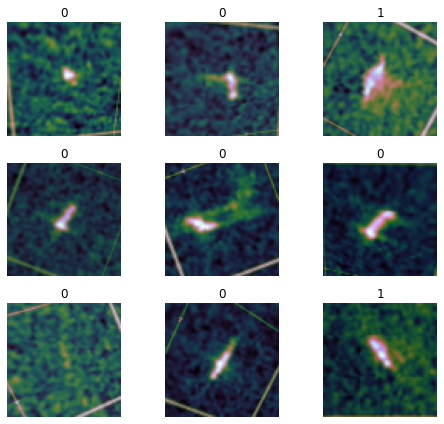

In [28]:
data.show_batch(rows=3, figsize=(7,6))

In [32]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(200)

In [0]:
learn.save('resnet34-band-1')
#learn.load('resnet34-band-1')

In [40]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


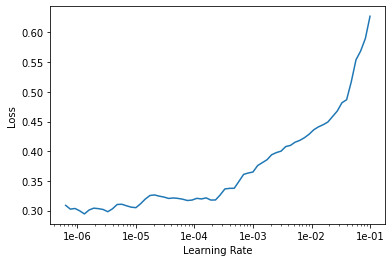

In [41]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3*16, max_lr=slice(1e-6,1e-4))

In [0]:
learn.save('resnet34-band-1')

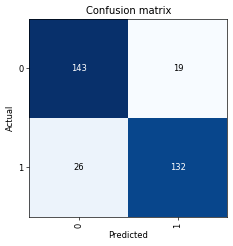

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

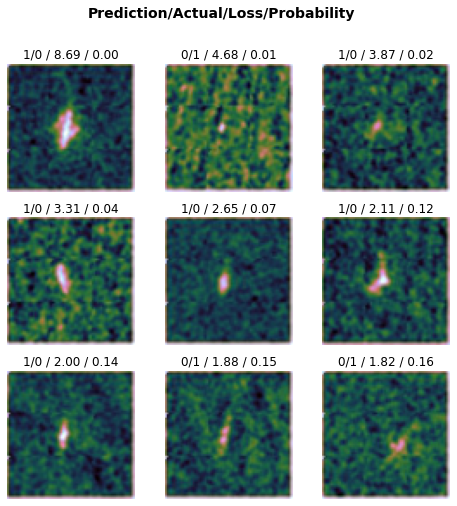

In [51]:
interp.plot_top_losses(9, figsize=(8,8))

### Make predictions for the train and the test datasets (Resnet-34, band_1)

In [0]:
learn.load('resnet34-band-1')

torch.Size([1604, 2])


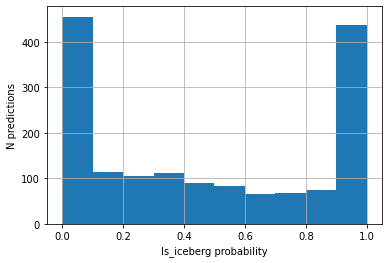

In [60]:
# add train dataset as Test to make predictions
test = ImageList.from_folder(get_path(True, 'band_1'))
data.add_test(test)
# predict
preds = learn.get_preds(DatasetType.Test)

print(preds[0].shape)
_ = plt.hist(preds[0][:, 1])
plt.xlabel('Is_iceberg probability')
plt.ylabel('N predictions')
plt.grid()

In [0]:
(pd.DataFrame()
  .assign(pred = preds[0][:, 1],
          # extract id from filenames
          id = [str(j)[9:str(j).find('.jpg')] for j in test.items])
).to_csv('resnet34_train_band_1_result.csv', index=False)

torch.Size([3424, 2])


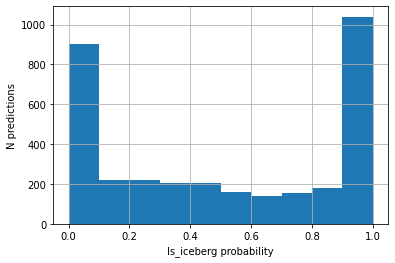

In [62]:
# add test dataset as Test to make predictions
test = ImageList.from_folder(get_path(False, 'band_1'))
data.add_test(test)
# predict
preds = learn.get_preds(DatasetType.Test)

print(preds[0].shape)
_ = plt.hist(preds[0][:, 1])
plt.xlabel('Is_iceberg probability')
plt.ylabel('N predictions')
plt.grid()

In [0]:
(pd.DataFrame()
  .assign(pred = preds[0][:, 1],
          # extract id from filenames
          id = [str(j)[9:str(j).find('.jpg')] for j in test.items])
).to_csv('resnet34_test_band_1_result.csv', index=False)

In [0]:
# move results to Google Drive
!mv *.csv ../content/drive/'My Drive'/

### Train Resnet-34 model on train/band_2 dataset

In [69]:
fnames = get_image_files(get_path(True, 'band_2'))
fnames[:5]

[PosixPath('sample_data/statoil/train/band_2/0_efc00a93.jpg'),
 PosixPath('sample_data/statoil/train/band_2/0_7e02f2d0.jpg'),
 PosixPath('sample_data/statoil/train/band_2/0_261d5678.jpg'),
 PosixPath('sample_data/statoil/train/band_2/1_62e844e7.jpg'),
 PosixPath('sample_data/statoil/train/band_2/1_8acbcd96.jpg')]

In [70]:
data = ImageDataBunch.from_name_re(get_path(True, 'band_2'),
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(flip_vert=True, max_rotate=30., max_zoom=1.1),
                                   size=74,
                                   bs=bs).normalize()
data.c

2

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [72]:
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,error_rate,time
0,1.149730,0.654355,0.384375,00:04
1,1.087808,0.655390,0.337500,00:04
2,1.064016,0.584966,0.315625,00:04
3,1.021706,0.558722,0.290625,00:04
4,1.001262,0.548354,0.284375,00:04
5,0.990255,0.539104,0.271875,00:04
6,0.969839,0.527855,0.259375,00:04
7,0.943577,0.519590,0.278125,00:04
8,0.921833,0.528494,0.300000,00:04
9,0.896138,0.532129,0.303125,00:04


In [0]:
learn.save('resnet34-band-2')
#learn.load('resnet34-band-1')

In [74]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


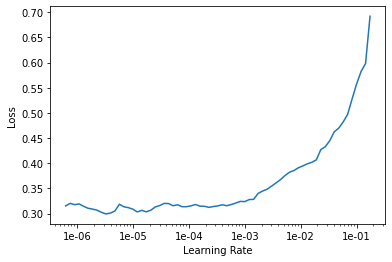

In [75]:
learn.recorder.plot()

In [77]:
learn.unfreeze()
learn.fit_one_cycle(1*16, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.310414,0.347187,0.175000,00:05
1,0.305040,0.343672,0.178125,00:05
2,0.303398,0.345613,0.171875,00:05
3,0.312235,0.345526,0.175000,00:05
4,0.311843,0.347352,0.178125,00:05
5,0.310552,0.349365,0.178125,00:05
6,0.310434,0.355822,0.193750,00:05
7,0.309451,0.353728,0.184375,00:05
8,0.306725,0.354693,0.190625,00:05
9,0.306858,0.352243,0.193750,00:05


In [0]:
# unsuccessful learning

#learn.save('resnet34-band-1')
learn.load('resnet34-band-2')

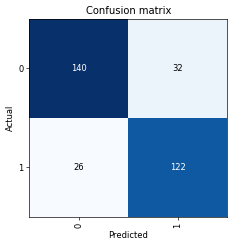

In [79]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

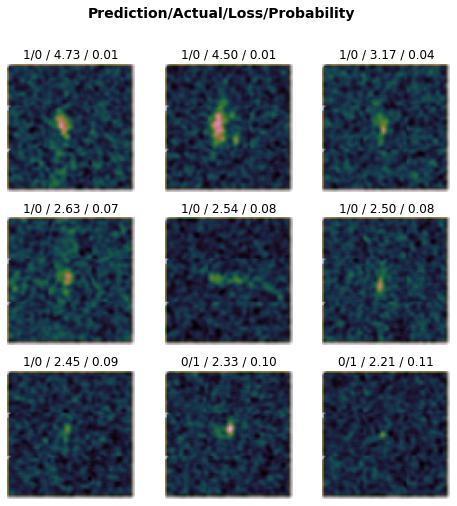

In [80]:
interp.plot_top_losses(9, figsize=(8,8))

### Make predictions for the train and the test datasets (Resnet-34, band_2)

In [81]:
learn.load('resnet34-band-2')

Learner(data=ImageDataBunch;

Train: LabelList (1284 items)
x: ImageList
Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74)
y: CategoryList
0,0,0,1,1
Path: sample_data/statoil/train/band_2;

Valid: LabelList (320 items)
x: ImageList
Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74),Image (3, 74, 74)
y: CategoryList
0,0,1,0,0
Path: sample_data/statoil/train/band_2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

torch.Size([1604, 2])


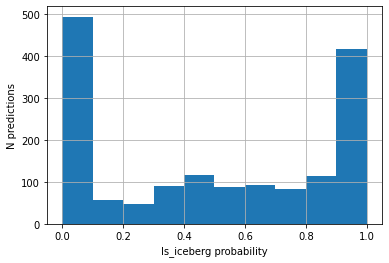

In [82]:
# add train dataset as Test to make predictions
test = ImageList.from_folder(get_path(True, 'band_2'))
data.add_test(test)
# predict
preds = learn.get_preds(DatasetType.Test)

print(preds[0].shape)
_ = plt.hist(preds[0][:, 1])
plt.xlabel('Is_iceberg probability')
plt.ylabel('N predictions')
plt.grid()

In [0]:
(pd.DataFrame()
  .assign(pred = preds[0][:, 1],
          # extract id from filenames
          id = [str(j)[9:str(j).find('.jpg')] for j in test.items])
).to_csv('resnet34_train_band_2_result.csv', index=False)

torch.Size([3424, 2])


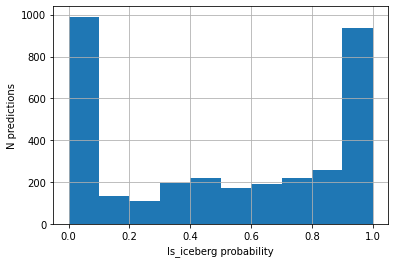

In [84]:
# add test dataset as Test to make predictions
test = ImageList.from_folder(get_path(False, 'band_2'))
data.add_test(test)
# predict
preds = learn.get_preds(DatasetType.Test)

print(preds[0].shape)
_ = plt.hist(preds[0][:, 1])
plt.xlabel('Is_iceberg probability')
plt.ylabel('N predictions')
plt.grid()

In [0]:
(pd.DataFrame()
  .assign(pred = preds[0][:, 1],
          # extract id from filenames
          id = [str(j)[9:str(j).find('.jpg')] for j in test.items])
).to_csv('resnet34_test_band_2_result.csv', index=False)

In [0]:
# move results to Google Drive
!mv *.csv ../content/drive/'My Drive'/